**1.**
Questa cella installa le librerie necessarie per eseguire il codice. Usiamo transformers per il modello BERT, torch per le operazioni sui tensori, scikit-learn per la divisione del dataset e le metriche, nltk per il preprocessing del testo e tabulate per la visualizzazione tabellare (anche se non usato esplicitamente). Specificando transformers>=4.30.0 ci assicuriamo di avere una versione recente per evitare problemi con parametri deprecati come pad_to_max_length.

In [5]:
# Installazione delle librerie necessarie
!pip install transformers>=4.30.0
!pip install torch
!pip install tabulate
!pip install scikit-learn
!pip install nltk

**2**.
Questa cella importa tutte le librerie e i moduli necessari per il progetto, incluse le funzioni per il preprocessing del testo, la gestione dei dati, l'addestramento del modello e la visualizzazione dei risultati. Verifica la versione di transformers per confermare che sia aggiornata e controlla la disponibilità della GPU, spostando il modello sul dispositivo appropriato (GPU o CPU). La stampa delle informazioni sul dispositivo aiuta a confermare che l'ambiente è configurato correttamente.

In [6]:
import numpy as np
import pandas as pd
import time
import datetime
import random
import nltk
nltk.download('stopwords')
import re
from tabulate import tabulate
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Verifica della versione di transformers
print("Transformers version:", transformers.__version__)

# Verifica della disponibilità della GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("GPU available:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using CPU.")
print("Device in use:", device)

Transformers version: 4.56.1
GPU available: Tesla T4
Device in use: cuda:0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**3**.
Questa cella carica il dataset movie_cleaned.csv, che contiene due colonne: text (recensioni di film) e label (etichette binarie 0 per negative, 1 per positive). Stampa le prime 10 righe per un controllo visivo e mostra la distribuzione delle etichette usando Counter per verificare il bilanciamento delle classi. Il codice include un'opzione commentata per caricare il file manualmente tramite l'interfaccia di Colab, utile se non è già presente in /content/.

In [7]:

df = pd.read_csv("/content/movie_cleaned.csv", engine="python", on_bad_lines='warn')
print("Dataset loaded successfully.")

# Controllo valori mancanti o vuoti
print("Valori mancanti in 'text':", df['text'].isna().sum())
print("Frasi vuote in 'text':", df['text'].apply(lambda x: isinstance(x, str) and len(x.strip()) == 0).sum())
print(df.head(10))
print("Label distribution:", Counter(df['label']))

Dataset loaded successfully.
Valori mancanti in 'text': 0
Frasi vuote in 'text': 0
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
5  A terrible movie as everyone has said. What ma...      0
6  Finally watched this shocking movie last night...      1
7  I caught this film on AZN on cable. It sounded...      0
8  It may be the remake of 1987 Autumn's Tale aft...      1
9  My Super Ex Girlfriend turned out to be a plea...      1
Label distribution: Counter({1: 19908, 0: 19815})


**4**.
Questa cella definisce una funzione clean_text per preprocessare il testo, rimuovendo URL, tag HTML, punteggiatura ed emoji, e convertendo il testo in minuscolo. La rimozione delle stopwords è commentata, poiché BERT è progettato per gestire testo grezzo e le stopwords possono contenere informazioni utili. La funzione gestisce anche valori non validi (es. non stringhe) restituendo una stringa vuota. Il preprocessing viene applicato alla colonna text del dataset, preparando i dati per la tokenizzazione.

In [8]:
# Funzione per il preprocessing del testo (versione minimale per BERT)
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_text(text):
    if not isinstance(text, str):
        return ""  # Gestisci valori non stringa
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Rimuovi URL
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)  # Rimuovi HTML
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p, '')  # Rimuovi punteggiatura
    # Opzionale: rimuovi stopwords, ma non sempre necessario per BERT
    # text = [word for word in text.split() if word not in sw]
    # text = " ".join(text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)  # Rimuovi emoji
    return text

df['text'] = df['text'].apply(clean_text)
print("Text preprocessing completed.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text preprocessing completed.


**5**.
Questa cella mescola il dataset per randomizzare l'ordine delle righe, riducendo il rischio di bias legati all'ordine dei dati. Divide quindi il dataset in train (80%) e test (20%) usando train_test_split con l'opzione stratify per mantenere il bilanciamento delle classi. Estrae le sentences e le labels dal set di training per la successiva tokenizzazione. La stampa delle dimensioni e della distribuzione delle etichette aiuta a verificare la correttezza della divisione.

In [9]:
# Mescola il dataset (shuffle)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Dataset shuffled.")

# Divisione in train e test (80-20, stratificata per label)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print('Train length:', len(train_df))
print(train_df.groupby(['label'])['text'].count())
print('Test length:', len(test_df))
print(test_df.groupby(['label'])['text'].count())

# Definizione delle sentences e labels per il train
sentences = train_df['text'].tolist()
labels = train_df['label'].tolist()

Dataset shuffled.
Train length: 31778
label
0    15852
1    15926
Name: text, dtype: int64
Test length: 7945
label
0    3963
1    3982
Name: text, dtype: int64


**6**.
Questa cella carica il tokenizer di BERT (bert-base-uncased) e calcola la lunghezza massima e media delle frasi per determinare un valore appropriato per MAX_LEN. Imposta MAX_LEN=128 come default, un compromesso tra copertura delle frasi e efficienza computazionale. Tokenizza le frasi del train set usando encode_plus, assicurando padding e troncamento a MAX_LEN con padding='max_length' e truncation=True. Filtra frasi vuote o non valide e verifica che tutti i tensori abbiano la forma corretta (1, 128) prima della concatenazione, evitando il RuntimeError. Infine, concatena i tensori e stampa le loro dimensioni.

In [10]:
# Caricamento del tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Calcolo della lunghezza massima e media delle sentences
max_len = 0
l = []
for sent in sentences:
    if isinstance(sent, str):  # Gestisci eventuali valori non stringa
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        l.append(len(input_ids))
        max_len = max(max_len, len(input_ids))
if max_len > 512:
    max_len = 512
avg_len = int(sum(l) / len(l)) if l else 0
print('Max sentence length:', max_len)
print('Avg sentence length:', avg_len)

# Imposta MAX_LEN
MAX_LEN = 256  # Aumentato per catturare più contesto

# Tokenizzazione
input_ids = []
attention_masks = []

# Filtra sentences vuote o non valide
valid_sentences = [sent for sent in sentences if isinstance(sent, str) and len(sent.strip()) > 0]
valid_labels = [labels[i] for i in range(len(sentences)) if isinstance(sentences[i], str) and len(sentences[i].strip()) > 0]
if len(valid_sentences) != len(sentences):
    print(f"Warning: {len(sentences) - len(valid_sentences)} empty or invalid sentences were removed.")

for sent in valid_sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Verifica le shape dei tensori
for i, input_id in enumerate(input_ids):
    if input_id.shape != (1, MAX_LEN):
        print(f"Inconsistent shape at index {i}: {input_id.shape}")
        print(f"Sentence: {valid_sentences[i]}")

# Concatena i tensori
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(valid_labels, dtype=torch.long)

print(f"Input IDs shape: {input_ids.shape}")
print(f"Attention Masks shape: {attention_masks.shape}")
print(f"Labels shape: {labels.shape}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors


Max sentence length: 512
Avg sentence length: 267
Input IDs shape: torch.Size([31778, 256])
Attention Masks shape: torch.Size([31778, 256])
Labels shape: torch.Size([31778])


**7**. Questa cella crea un TensorDataset combinando input_ids, attention_masks e labels del train set. Divide il dataset in training (80%) e validation (20%) usando random_split. Configura i DataLoader per il training (con RandomSampler per mescolare i dati) e la validazione (con SequentialSampler per un ordine fisso), usando un batch_size=16 per bilanciare efficienza e stabilità del training. La stampa delle dimensioni dei set aiuta a verificare la suddivisione.#

In [11]:
# Crea il dataset e dividilo in train/validation (80-20)
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('Training samples:', train_size)
print('Validation samples:', val_size)

# Batch size
batch_size = 16

# DataLoader per train e validation
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

Training samples: 25422
Validation samples: 6356


**8**.
Questa cella carica il modello BertForSequenceClassification con bert-base-uncased, configurato per classificazione binaria (num_labels=2). Disabilita l'output delle attenzioni e degli stati nascosti per ridurre il consumo di memoria. Sposta il modello sul dispositivo (GPU o CPU). Configura l'ottimizzatore AdamW con un learning rate di 2e-5 (valore consigliato per BERT) e uno scheduler lineare senza warmup per semplificare. Specifica 4 epoche per il training, un numero standard per il fine-tuning di BERT.

In [12]:
# Caricamento del modello BERT per classificazione
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,  # Classificazione binaria
    output_attentions=False,
    output_hidden_states=False,
)
# Aggiungi dropout al classificatore
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(model.classifier.in_features, model.classifier.out_features)
)
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Numero di epoche
epochs = 4

# Scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**9**.
Questa cella definisce due funzioni di supporto: flat_accuracy per calcolare l'accuratezza delle predizioni confrontando i logits (dopo argmax) con le etichette vere, e format_time per convertire i tempi di esecuzione in un formato leggibile (ore:minuti:secondi). Queste funzioni sono utilizzate nel training e nella validazione per monitorare le prestazioni e i tempi.

In [13]:
# Funzione per calcolare l'accuratezza
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Funzione per formattare il tempo
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

**10**.
Questa cella implementa il ciclo di addestramento per il modello BERT. Imposta un seed per la riproducibilità, esegue il training per 4 epoche e calcola la loss media per il training e la validazione. Durante il training, applica il clipping dei gradienti per prevenire esplosioni dei gradienti e aggiorna i parametri con l'ottimizzatore e lo scheduler. Durante la validazione, calcola accuratezza e F1-score, salvando il modello con la migliore accuratezza di validazione (usando state_dict per compatibilità). Raccoglie statistiche per ogni epoca (loss, accuratezza, F1-score, tempi).

In [14]:
# Training loop
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()
best_eval_accuracy = 0
patience = 2
epochs_no_improve = 0

for epoch_i in range(epochs):
    print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    print("\nRunning Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        logits = output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += f1_score(label_ids, np.argmax(logits, axis=1), average='binary')
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  F1-Score: {avg_val_f1:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    # Salva il modello migliore e verifica early stopping
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model.state_dict(), 'bert_model.pt')
        best_eval_accuracy = avg_val_accuracy
        epochs_no_improve = 0
        print("  Best model saved!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch_i + 1} epochs")
            break

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Valid. F1': avg_val_f1,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("\nTraining complete!")
print(f"Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")


======== Epoch 1 / 4 ========
Training...
  Average training loss: 0.28
  Training epoch took: 0:18:36

Running Validation...
  Accuracy: 0.90
  F1-Score: 0.90
  Validation Loss: 0.26
  Validation took: 0:01:30
  Best model saved!

======== Epoch 2 / 4 ========
Training...
  Average training loss: 0.16
  Training epoch took: 0:18:43

Running Validation...
  Accuracy: 0.91
  F1-Score: 0.91
  Validation Loss: 0.30
  Validation took: 0:01:30
  Best model saved!

======== Epoch 3 / 4 ========
Training...
  Average training loss: 0.08
  Training epoch took: 0:18:44

Running Validation...
  Accuracy: 0.92
  F1-Score: 0.91
  Validation Loss: 0.39
  Validation took: 0:01:30
  Best model saved!

======== Epoch 4 / 4 ========
Training...
  Average training loss: 0.04
  Training epoch took: 0:18:44

Running Validation...
  Accuracy: 0.92
  F1-Score: 0.91
  Validation Loss: 0.45
  Validation took: 0:01:30

Training complete!
Total training took 1:21:20 (h:mm:ss)


*12*.
Questa cella crea un DataFrame con le statistiche di training (loss, accuratezza, F1-score, tempi) e le visualizza in forma tabellare. Genera due grafici: uno per la loss di training e validazione, utile per diagnosticare overfitting/underfitting, e uno per l'accuratezza di validazione, per valutare la convergenza del modello. I grafici usano seaborn per uno stile chiaro e leggibile.

       Training Loss  Valid. Loss  Valid. Accur.  Valid. F1 Training Time  \
epoch                                                                       
1           0.279543     0.255577       0.896200   0.895545       0:18:36   
2           0.157586     0.302196       0.911903   0.905244       0:18:43   
3           0.083235     0.386965       0.915358   0.908625       0:18:44   
4           0.043535     0.452589       0.915358   0.908002       0:18:44   

      Validation Time  
epoch                  
1             0:01:30  
2             0:01:30  
3             0:01:30  
4             0:01:30  


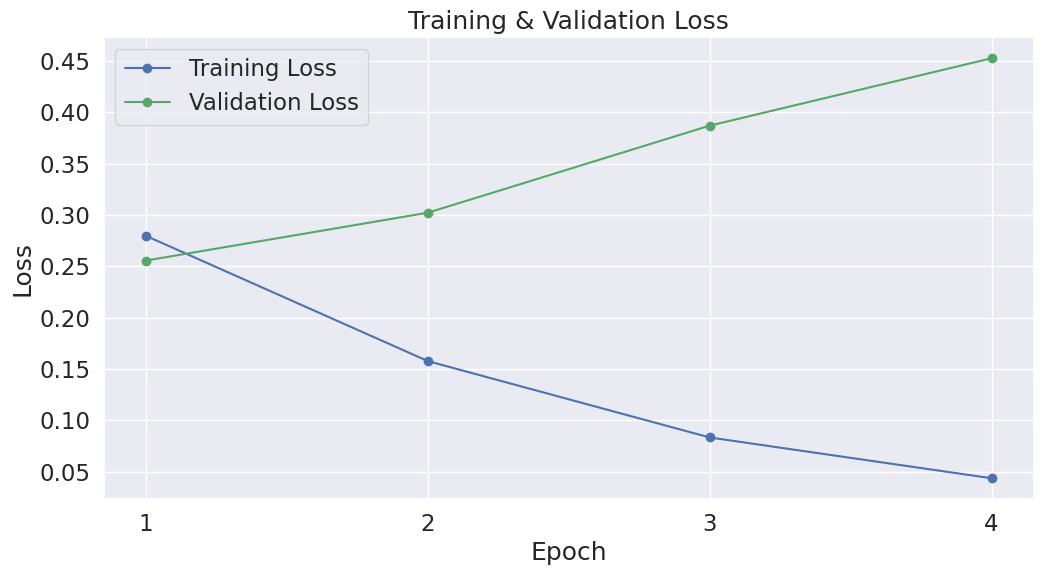

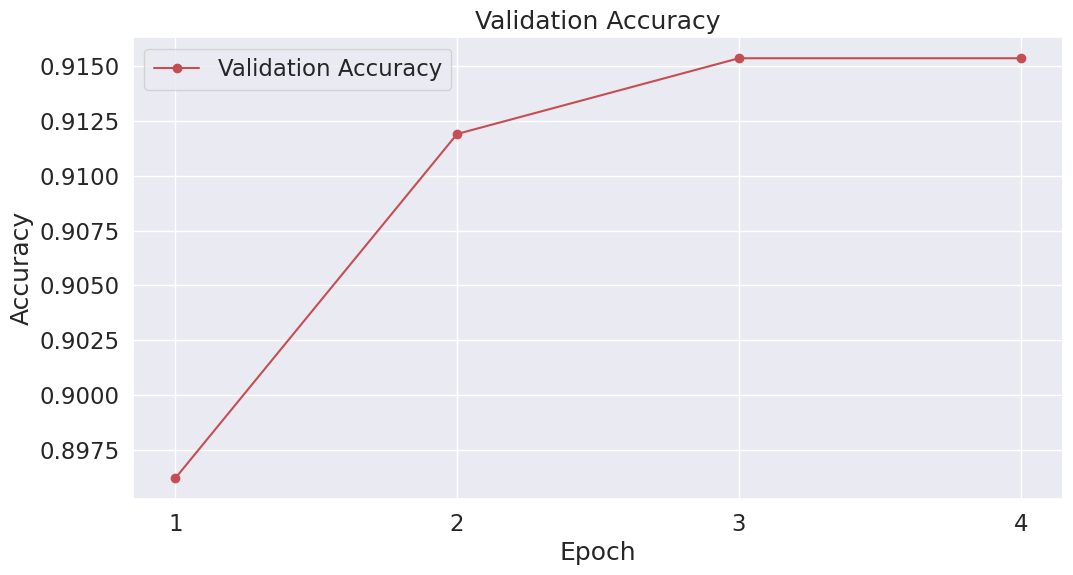

In [15]:
# Visualizzazione delle statistiche di training
df_stats = pd.DataFrame(data=training_stats).set_index('epoch')
print(df_stats)

# Plot della learning curve
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1, len(df_stats) + 1))
plt.show()

# Plot dell'accuratezza
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(range(1, len(df_stats) + 1))
plt.show()

**13**.
Questa cella carica il modello migliore (salvato come bert_model.pt) e valuta le sue prestazioni sul test set. Tokenizza il test set con lo stesso processo usato per il train set, filtrando frasi vuote e verificando le shape dei tensori. Crea un DataLoader con batch_size=32 per l'inferenza e calcola le predizioni. Riporta l'accuratezza, l'F1-score e un report di classificazione dettagliato. Infine, visualizza una matrice di confusione normalizzata per analizzare gli errori di classificazione.

Predicting labels for test sentences...
Test Accuracy: 0.9247325361862807
Test F1-Score: 0.9255107125062282
              precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      3963
    Positive       0.92      0.93      0.93      3982

    accuracy                           0.92      7945
   macro avg       0.92      0.92      0.92      7945
weighted avg       0.92      0.92      0.92      7945



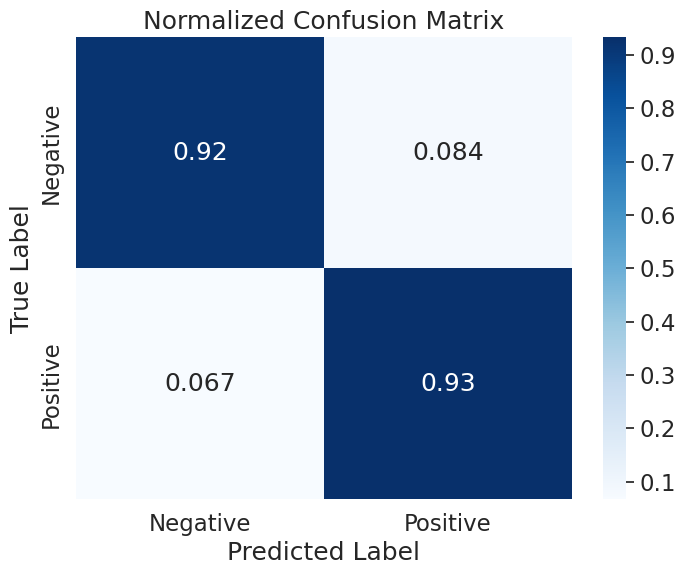


Esempi mal classificati (primi 5):
Testo: most of the comments have been positive but i would like to add that viewers should also focus on the sets the set designer used a lot of beautiful art deco treatments along with beautiful buildings, stairs, doors, furniture and so forth it is worth paying attention to the movie is driven by characterization and symbolism which is very rich all the gangster actors were cast  it was like seeing old friends and it was a treat the dialog was amusing at times but stilted at times and i suppose it was meant to be that way this is a film buffs film it was made by people, for people who love the medium dont miss this one
Vero: 1, Predetto: 0

Testo: having been born and raised in odessa, and having graduated from the "other" high school in the late 70s, odessa high school, i had mixed emotions about this movie i no longer live in odessa, but will always be a texan at heart i didnt like the way that this town of 80,000 plus was portrayed as a dirt poo

In [16]:
# Caricamento del modello migliore
model.load_state_dict(torch.load('bert_model.pt'))
model = model.to(device)
model.eval()

# Tokenizzazione del test set
sentences = test_df['text'].tolist()
labels = test_df['label'].tolist()

input_ids = []
attention_masks = []

# Filtra sentences vuote o non valide
valid_sentences = [sent for sent in sentences if isinstance(sent, str) and len(sent.strip()) > 0]
valid_labels = [labels[i] for i in range(len(sentences)) if isinstance(sentences[i], str) and len(sentences[i].strip()) > 0]
if len(valid_sentences) != len(sentences):
    print(f"Warning: {len(sentences) - len(valid_sentences)} empty or invalid sentences were removed from test set.")

for sent in valid_sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Verifica le shape
for i, input_id in enumerate(input_ids):
    if input_id.shape != (1, MAX_LEN):
        print(f"Inconsistent shape at index {i} in test set: {input_id.shape}")
        print(f"Sentence: {valid_sentences[i]}")

# Concatena
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(valid_labels, dtype=torch.long)

# DataLoader per il test set
batch_size = 32
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Predizioni
print('Predicting labels for test sentences...')
predictions, true_labels = [], []
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)

# Flattena le predizioni
from functools import reduce
scores = reduce(lambda x, y: x + y, [list(map(np.argmax, p)) for p in predictions])
true_labels_flat = reduce(lambda x, y: list(x) + list(y), true_labels)

# Metriche
print("Test Accuracy:", accuracy_score(true_labels_flat, scores))
print("Test F1-Score:", f1_score(true_labels_flat, scores, average='binary'))
print(classification_report(true_labels_flat, scores, target_names=['Negative', 'Positive']))

# Matrice di confusione
cm = confusion_matrix(true_labels_flat, scores)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cm_normalized, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Stampa esempi mal classificati
incorrect_indices = [i for i in range(len(scores)) if scores[i] != true_labels_flat[i]]
print("\nEsempi mal classificati (primi 5):")
for idx in incorrect_indices[:5]:
    print(f"Testo: {valid_sentences[idx]}")
    print(f"Vero: {true_labels_flat[idx]}, Predetto: {scores[idx]}\n")